### Your very own neural network

In this notebook we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

<img src="frankenstein.png" style="width:20%">

In [1]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)
import scipy.stats

Here goes our main class: a layer that can do .forward() and .backward() passes.

In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self, uid, params=None):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        self._training = True
        self._output_units = None
        self._num_params = 0
        prefix = self.__class__.__name__
        self._name = prefix.lower() + '_' + str(uid)
        self._type = ''        
        if params is not None:
            self.learning_rate = params.get('learning_rate', 0.1)
            self.optim = params.get('optim', 'sgd')
            self.momentum = params.get('momentum', 0.0)
            self.nesterov = params.get('nesterov', False) if (self.optim == 'sgd') else False
        
        self.velocity = [0.0, 0.0]
        #pass
    
    @property
    def training(self):
        return self._training
    
    @property
    def output_units(self):
        return self._output_units
        
    @property
    def name(self):
        return self._name
    
    @property
    def num_params(self):
        return self._num_params
    
    @property
    def type(self):
        return self._type
            
    def set_train_mode(self, mode=True):
        self._training = mode
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule
    
    def regularization_penalty(self):
        return 0
    
    def _update_params(self, p, gradp, velocity, reg_fn='None', l2_scale=0.0, l1_scale=0.0):
        if reg_fn == 'l2':
            gradp += (l2_scale*2*p)
        elif reg_fn == 'l1':
            gradp += (l1_scale*2)
        elif reg_fn == 'l1_l2':
            gradp += (l1_scale*2 + l2_scale*2*p)
            
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        if self.optim == 'sgd':
            # Momentum update
            #    v = mu * v - learning_rate * dx # integrate velocity
            #    x += v # integrate position

            # Nesterov update:
            #    x_ahead = x + mu * v
            # evaluate dx_ahead (the gradient at x_ahead instead of at x)
            #    v = mu * v - learning_rate * dx_ahead
            #    x += v
            
            # In practice
            #    v_prev = v # back this up
            #    v = mu * v_prev - learning_rate * dx # velocity update stays the same
            #    x += -mu * v_prev + (1 + mu) * v # position update changes form
            
            velocity = (self.momentum*velocity) - (self.learning_rate*gradp)
            if self.nesterov:
                p += (self.momentum*velocity)- (self.learning_rate*gradp)
            else:
                p += velocity

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [5]:
import copy
def get_uids():
    params = {
    'Relu': 1,
    'Dense': 1,
    'Dropout': 1,
    'BatchNorm': 1
    }
    return copy.deepcopy(params)
    
def get_reg_params():
    params = {
    'reg_fn': None,
    'l2_scale': 0.0,
    'l1_scale': 0.0
    }
    return copy.deepcopy(params)
    
def get_default_params():
    params = {
    'learning_rate': 0.1, 
    'init_fn': 'normal',
    'dense_reg': get_reg_params(),
    'optim': 'sgd',        
    'momentum': 0.0,
    'nesterov': False,
    'drop_prob': 0.0,
    'bn': False,
    'bn_momentum': 0.99,
    'bn_eps': 0.001,
    'bn_gamma_reg': get_reg_params(),
    'bn_beta_reg': get_reg_params(),
    'uids': get_uids()
    }
    
    return copy.deepcopy(params)

In [6]:
class ReLU(Layer):
    def __init__(self, params):
        super(ReLU, self).__init__(params['uids']['Relu'])
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self._type = 'Activation'
        params['uids']['Relu'] += 1
       
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return np.maximum(0, input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [7]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
params = get_default_params()
l = ReLU(params)
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [8]:
class Dense(Layer):
    def __init__(self, input_units, output_units, params):
        super(Dense, self).__init__(params['uids']['Dense'], params)
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        params['uids']['Dense'] += 1
        self.init_fn = params.get('init_fn', 'normal')
        self.regulizer = params.get('dense_reg', None)
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = self._initializer(input_units, output_units, stddev=0.01)
        self._num_params = input_units*output_units
        self.biases = np.zeros(output_units)
        self._num_params += output_units
        
        self._type = 'Layer'
        self._output_units = output_units
       
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        if self.nesterov and self.training:
            self.weights += self.momentum*self.velocity[0]
            self.biases += self.momentum*self.velocity[1]
            
        return input.dot(self.weights) + self.biases

    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output.dot(self.weights.T) #<your code here>
        
        # compute gradient w.r.t. weights and biases
        grad_weights = (input.T).dot(grad_output) #<your code here>
        grad_biases = grad_output.sum(axis = 0) #<your code here>
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        self._update_params(self.weights, grad_weights, self.velocity[0], **self.regulizer)
        self._update_params(self.biases, grad_biases, self.velocity[1])
        
        return grad_input
    
    def regularization_penalty(self):
        if self.regulizer['reg_fn'] == 'l2':
            val = self.regulizer['l2_scale']*np.sum(self.weights**2)
        elif self.regulizer['reg_fn'] == 'l1':
            val = self.regulizer['l1_scale']*np.sum(np.abs(self.weight))
        elif self.regulizer['reg_fn'] == 'l1_l2':
            val = self.regulizer['l1_scale']*np.sum(np.abs(self.weight)) + self.regulizer['l2_scale']*np.sum(self.weights**2)
        else:
            val = 0.0
        return val

    def _initializer(self, inp, outp, mean=0.0, stddev=0.01):
        if self.init_fn == 'xavier_normal':
            scale = np.sqrt(2.0/(inp+outp))
            scale /= .87962566103423978 #Truncated Normal Distribution
            #init = np.random.randn(inp, outp)*scale
            init = scipy.stats.truncnorm.rvs(a=-2, b=2, loc=0., scale=scale, size=(inp, outp))
        elif self.init_fn == 'xavier_uniform':
            limit = np.sqrt(6.0/(inp+outp))
            init =  np.random.uniform(-limit, limit, (inp, outp)) 
        elif self.init_fn == 'normal':
            init = mean + np.random.randn(inp, outp)*stddev
        
        return init

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [9]:
params = get_default_params()
l = Dense(128, 150, params)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4,params)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [10]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

params = get_default_params()
x = np.linspace(-1,1,10*32).reshape([10,32])
params['learning_rate']=0
l = Dense(32,64,params)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [11]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    params = get_default_params()
    params['learning_rate']=1
    l = Dense(32,64,params)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    params = get_default_params()
    params['learning_rate']=1
    l = Dense(32,64,params)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [12]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [13]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

#softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

Using TensorFlow backend.
d:\install\miniconda3\envs\od36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\install\miniconda3\envs\od36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\install\miniconda3\envs\od36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\install\miniconda3\envs\od36\lib\site-packages\tensorflo

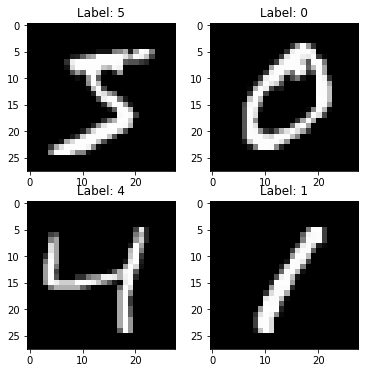

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [15]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(50000, 784) (50000,) (10000, 784) (10000,) (10000, 784) (10000,)


In [16]:
def summary(model):
    print('=================================================================')
    print('Layer (type)                 Output Shape                 Param #')
    print('=================================================================')
    
    output_units = None
    lens = [len('Layer (type)                 '), len('Output Shape                 ')]
    for layer in model:
        if layer.output_units is not None:
            output_units = layer.output_units
        name_type = layer.name + ' (' + layer.type + ')'
        name_type += ' ' * (lens[0]-len(name_type))
        
        out_shape = '(None, ' + str(output_units) + ')'
        out_shape += ' ' * (lens[1]-len(out_shape))
        
        print("{}{}{}".format(name_type, out_shape, layer.num_params))
        print('_________________________________________________________________')

In [17]:
params = get_default_params()
network = []
network.append(Dense(X_train.shape[1],100, params))
network.append(ReLU(params))
network.append(Dense(100,200, params))
network.append(ReLU(params))
network.append(Dense(200,10, params))
summary(network)

Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 100)                  78500
_________________________________________________________________
relu_1 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 200)                  20200
_________________________________________________________________
relu_2 (Activation)          (None, 200)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 10)                   2010
_________________________________________________________________


In [18]:
def regularization_penalty(network):
    losses = []
    for layer in network:
        losses.append(layer.regularization_penalty())
        
    return np.sum(losses)

def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # <your code here>
    for layer in network:
        activations.append(layer.forward(input))        
        input = activations[-1]
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    
    for layer in network:
        layer.set_train_mode(False)

    logits = forward(network,X)[-1]
    
    for layer in network:
        layer.set_train_mode(True)
        
    return logits.argmax(axis=-1), logits

def compute_loss(network, logits, y):
    # Compute the loss
    loss = softmax_crossentropy_with_logits(logits,y)
    loss = loss + regularization_penalty(network)
        
    return loss

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    accuracy = logits.argmax(axis=-1)==y
    
    # Compute the loss
    loss = compute_loss(network, logits, y)
    # Compute the initial gradient
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    for i in range(len(network)-1, -1, -1):
        loss_grad  = network[i].backward(layer_inputs[i], loss_grad)    
        
    return np.mean(loss), np.mean(accuracy)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [19]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [20]:
from IPython.display import clear_output
def plot(logs, keys=None, skeys=None, clr=True):
    if clr:
        clear_output()

    for key in logs:
        if keys is not None:
            no_plts = len(keys)
            skip = True
            for key1 in keys:
                if key1 in key:
                    skip = False
            if skip:
                continue
        else:
            no_plts = len(logs[key])
            
        idx = 1
        for skey in logs[key]:
            if skeys is not None and skey not in skeys:
                continue
        
            plt.subplot(1, len(logs[key]), idx)
            plt.plot(logs[key][skey], label=key+' '+skey)
            plt.legend(loc='best')
            idx += 1
    
    plt.grid()
    plt.show()

In [21]:
def initLog():
    logs = {}
    keys = ['train', 'val']
    skeys = ['accuracy', 'loss']
        
    for key in keys:
        logs[key] = {}
        for skey in skeys:
            logs[key][skey] = []
    
    return logs

In [22]:
def train_model(network, X_train,y_train, X_val, y_val, batch_sz=32, epochs=25):
    log = initLog()
    
    for epoch in range(epochs):
        
        loss_t = []
        acc_t = []
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batch_sz,shuffle=True):
            loss, acc = train(network,x_batch,y_batch)
            loss_t.append(loss)
            acc_t.append(acc)
    
        pred, _ = predict(network,X_train)
        log['train']['loss'].append(np.mean(loss_t))
        #log['train']['accuracy'].append(np.mean(acc_t))
        log['train']['accuracy'].append(np.mean(pred==y_train))

        pred, logits = predict(network,X_val)
        log['val']['loss'].append(np.mean(compute_loss(network, logits, y_val)))
        log['val']['accuracy'].append(np.mean(pred==y_val))
        
        plot(log)

        print("Epoch",epoch)
        print("Train loss, accuracy:", log['train']['loss'][-1], log['train']['accuracy'][-1])
        print("Val loss, accuracy:", log['val']['loss'][-1], log['val']['accuracy'][-1])
        
    return log

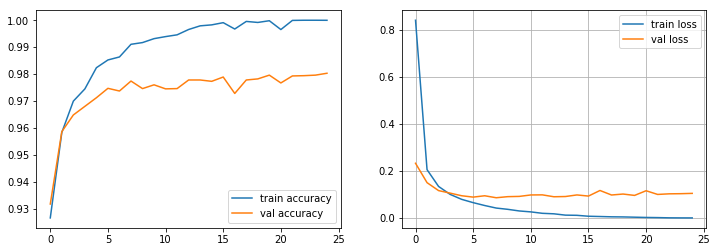

Epoch 24
Train loss, accuracy: 0.0006333537998645984 0.99998
Val loss, accuracy: 0.10502731808250562 0.9803


In [23]:
log = train_model(network, X_train,y_train, X_val, y_val)

In [24]:
pred, _ = predict(network,X_test)
print("Test accuracy:", np.mean(pred==y_test))

Test accuracy: 0.9812


### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.


In [25]:
class Dropout(Layer):
    def __init__(self, params):
        super(Dropout, self).__init__(params['uids']['Dropout'])
        self.keep_prob = 1 - params['drop_prob']
        if self.keep_prob > 0.0:
            self.scale = (1/self.keep_prob)
        else:
            self.scale = 0.0

        self._type = 'Dropout'
        params['uids']['Dropout'] += 1

            
    def forward(self, input):
        if not self.training:
            return input
        
        self.mask = np.random.uniform(0, 1.0, input.shape) < self.keep_prob
        self.mask = self.mask * self.scale
        return np.multiply(self.mask, input)
    
    def backward(self, input, grad_output):
        return np.multiply(self.mask, grad_output)

In [26]:
class BatchNormalization(Layer):
    def __init__(self, input_units, params):
        super(BatchNormalization, self).__init__(1, params)
        self.eps = params.get('bn_eps', 0.001)
        self.momentum = params.get('bn_momentum', 0.99)
        self.beta_reg = params.get('bn_beta_reg', None)
        self.gamma_reg = params.get('bn_gamma_reg', None)
        self.gamma = 1.0
        self.beta = 0.0
        self.moving_mean = np.zeros(input_units)
        self.moving_variance = np.zeros(input_units)
        self.gamma = np.ones(input_units)  # Add configurable Initializer later
        self.beta = np.zeros(input_units)  # Add configurable Initializer later
        
        self._name = 'BatchNorm_' + str(params['uids']['BatchNorm'])
        self._type = 'BatchNormalization'
        self._output_units = input_units
        self._num_params = input_units*4 # 4 for gamma, beta, moving_mean, moving_variane
        params['uids']['BatchNorm'] += 1
    
    def forward(self, input):
        if self.training:
            self.mean = input.mean(axis=0)
            self.var = input.var(axis=0)
            self.input_ms = (input-self.mean)
            self.input_hat = self.input_ms/np.sqrt(self.var+self.eps)
            out = self.input_hat*self.gamma + self.beta
            
            var = self.var * (input.shape[0]/(input.shape[0] - (1.0 + self.eps)))
            self.moving_mean = self.moving_mean * self.momentum + self.mean * (1 - self.momentum)
            self.moving_variance = self.moving_variance * self.momentum + var * (1 - self.momentum)
        else:
            input_hat = (input-self.moving_mean)/np.sqrt(self.moving_variance+self.eps)
            out = input_hat*self.gamma + self.beta
        
        return out
    
    def backward(self, input, grad_output):
        # d_loss/d_input_hat = (d_loss/d_out) * (d_out/d_input_hat)
        # d_out/d_input_hat = gamma
        # d_loss/d_input_hat = (d_loss/d_out) * gamma
        grad_input_hat = grad_output*self.gamma
        
        # d_loss/d_gamma = (d_loss/d_out) * (d_out/d_gamma)
        # d_out/d_gamma = input_hat
        # d_loss/d_gamma = (d_loss/d_out) * input_hat
        grad_gamma = (self.input_hat*grad_output).sum(axis=0)

        # d_loss/d_beta = (d_loss/d_out) * (d_out/d_beta)
        # d_out/d_beta = 1
        # d_loss/d_beta = (d_loss/d_out) * 1
        grad_beta = grad_output.sum(axis=0)
                
        # d_loss/d_var = (d_loss/d_input_hat) * (d_input_hat/d_var) 
        # d_input_hat/d_var = input_ms*(-1/2)*pow(var+eps, -3/2)
        # d_loss/d_var = (d_loss/d_input_hat) * input_ms *(-1/2)*pow(var+eps, -3/2)
        var_eps = (self.var+self.eps)
        grad_var = (-0.5*self.input_ms)*(var_eps**(-3/2))
        grad_var = (grad_input_hat*grad_var).sum(axis=0)
        
        inv_std = var_eps**(-1/2)
        
        # d_loss/d_mean = (d_loss/d_input_hat) * (d_input_hat/d_mean) + (d_loss/d_var) * (d_var/d_mean)
        # d_input_hat/d_mean = -1*pow(var+eps, -1/2)
        # d_var/d_mean = -2*sum(input_ms)/batch_size
        # d_loss/d_mean = -grad_input_hat*pow(var+eps, -1/2) + -2*grad_var*sum(input_ms)/batch_size
        grad_mean = (-grad_input_hat*inv_std).sum(axis=0)        
        grad_mean += (-2.0*grad_var*self.input_ms).sum(axis=0)/input.shape[0]
        
        # d_loss/d_input = (d_loss/d_input_hat) * (d_input_hat/d_input) + (d_loss/d_var) * (d_var/d_input) + (d_loss/d_mean) * (d_mean/d_input)
        # d_input_hat/d_input = pow(var+eps, -1/2)
        # d_var/d_input = 2*input_ms/batch_size
        # d_mean/d_input = 1/batch_size
        # d_loss/d_input = grad_input_hat*pow(var+eps, -1/2) + grad_var*2*input_ms/batch_size + grad_mean/batch_size
        grad_input = (grad_input_hat*inv_std) + ((2*grad_var*self.input_ms + grad_mean)/input.shape[0])

            
        self._update_params(self.gamma, grad_gamma, self.velocity[0], **self.gamma_reg)
        self._update_params(self.beta, grad_beta, self.velocity[1], **self.beta_reg)
            
        return grad_input

In [27]:
def create_network(params, hlayer_dims=[100, 200]):
    network = []
    
    layer_dims=[X_train.shape[1]]
    layer_dims.extend(hlayer_dims)
    layer_dims.append(10)

    num_layers = len(layer_dims)-1        
    for n in range(num_layers):
        network.append(Dense(layer_dims[n],layer_dims[n+1],params))
        
        if params['bn'] and (n < (num_layers-1)):
            network.append(BatchNormalization(layer_dims[n+1],params))

        if (n < (num_layers-1)):
            network.append(ReLU(params))

        if (n < (num_layers-1)) and (params['drop_prob'] > 0.0):
            network.append(Dropout(params))
    
    return network

In [28]:
def changeKeys(log, idx):
    n_log = {}
    for key in log.keys():        
        n_log[key+idx] = log[key]
        
    return n_log

In [29]:
def create_and_train_model(params, hlayer_dims=[100, 200], batch_sz=32, epochs=25, idx=None, get_init_w=False):
    
    network = create_network(params, hlayer_dims)
    if get_init_w:
        w = copy.copy(network[0].weights)
    else:
        w = None
        
    log = train_model(network, X_train,y_train, X_val, y_val, batch_sz=batch_sz, epochs=epochs)
    
    if idx is not None:
        log = changeKeys(log, idx)
        
    pred, _ = predict(network,X_test)
    print("Test accuracy:", np.mean(pred==y_test))
    
    summary(network)
    
    return network, log, w

In [30]:
def plot_weights(w1, w2, title=['Weights', 'Weights']):
    plt.subplot(1, 2, 1)
    plt.hist(w1.reshape((-1,)), bins=100)
    plt.title(title[0])
    plt.subplot(1, 2, 2)
    plt.hist(w2.reshape((-1,)), bins=100)
    plt.title(title[1])
    plt.show()

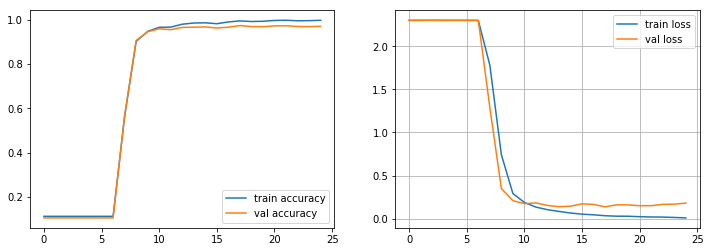

Epoch 24
Train loss, accuracy: 0.007719261980665514 0.99676
Val loss, accuracy: 0.17953509765729306 0.9698
Test accuracy: 0.9702
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 512)                  401920
_________________________________________________________________
relu_1 (Activation)          (None, 512)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 256)                  131328
_________________________________________________________________
relu_2 (Activation)          (None, 256)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 128)                  32896
_________________________________________________________________
relu_3 (Activation)          (None, 128)                  0
_________________________________________________________________
dense_4 (Layer)              (None,

In [31]:
# Option I: initialization: Xavier Uniform

# Default Normal Initialization on deep networks (5+ layers)
hlayer_dims = [512, 256, 128, 80]
params = get_default_params()
params['learning_rate']=0.05
nw_I_def, log_I_def, w_I_def = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=25, idx='_I_def', get_init_w=True)

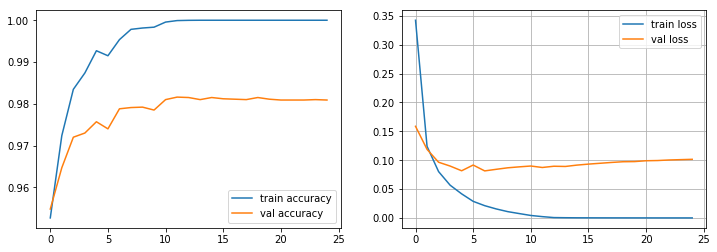

Epoch 24
Train loss, accuracy: 0.00011731220546146072 1.0
Val loss, accuracy: 0.1015651816254098 0.9809
Test accuracy: 0.9828
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 512)                  401920
_________________________________________________________________
relu_1 (Activation)          (None, 512)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 256)                  131328
_________________________________________________________________
relu_2 (Activation)          (None, 256)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 128)                  32896
_________________________________________________________________
relu_3 (Activation)          (None, 128)                  0
_________________________________________________________________
dense_4 (Layer)              (None, 80

In [32]:
# Xavier Uniform Initialization on deep networks (5+ layers)
params['uids'] = get_uids()
params['init_fn']='xavier_uniform'
nw_I_xav, log_I_xav, w_I_xav = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=25, idx='_I_xav', get_init_w=True)

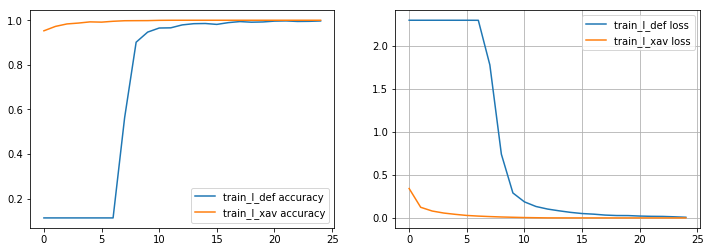

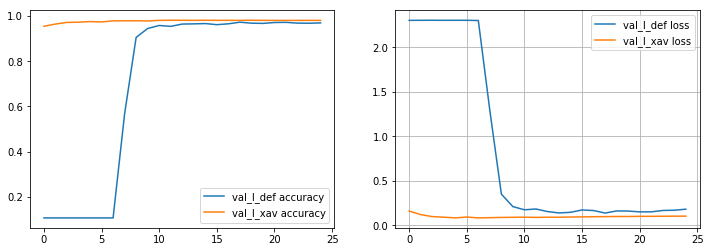

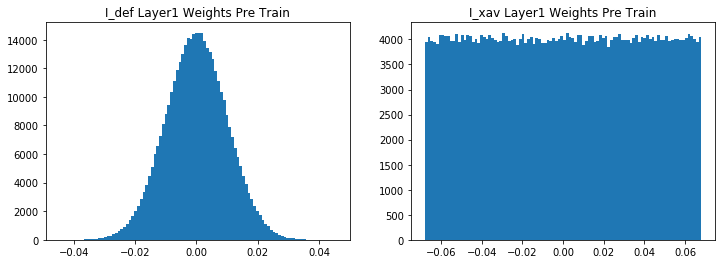

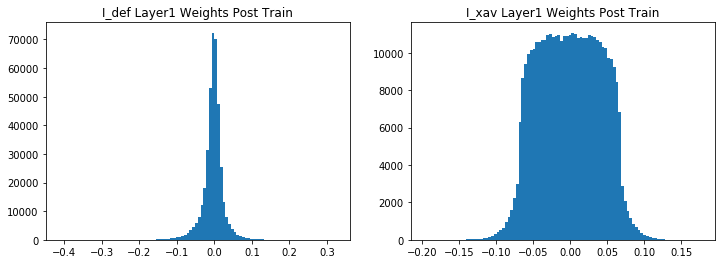

In [33]:
# Compare Xavier vs Default Initialization

log_comp_I = {**log_I_def, **log_I_xav}
plot(log_comp_I, keys=['train'])
plot(log_comp_I, keys=['val'], clr=False)
plot_weights(w_I_def, w_I_xav, ['I_def Layer1 Weights Pre Train', 'I_xav Layer1 Weights Pre Train'])
plot_weights(nw_I_def[0].weights, nw_I_xav[0].weights, ['I_def Layer1 Weights Post Train', 'I_xav Layer1 Weights Post Train'])

As can be seen from graphs above
1. If weights in a network start too small, their gradient tends to get smaller during back propagation. Hence neurons in the earlier layers learn much more slowly than neurons in later layers. This causes minor weight updates. This can lead to weights vanishing to 0, a phenomenon called vanishing gradient problem
2. Xavier initialization makes sure the weights are ‘just right’, keeping the signal in a reasonable range of values through many layers. It helps maintain the variance of activations and back-propagated gradients all the way up or down the layers of a network

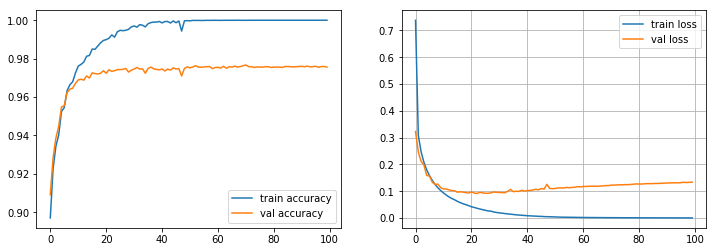

Epoch 99
Train loss, accuracy: 0.0007556145474473544 1.0
Val loss, accuracy: 0.13399865654319143 0.9756
Test accuracy: 0.9762
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 100)                  78500
_________________________________________________________________
relu_1 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 100)                  10100
_________________________________________________________________
relu_2 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 100)                  10100
_________________________________________________________________
relu_3 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_4 (Layer)              (None, 10) 

In [34]:
# Option II: regularization

# No regularization
hlayer_dims = [100, 100, 100]
params = get_default_params()
params['learning_rate']=0.01
params['init_fn']='xavier_uniform'
nw_II_def, log_II_def, w_II_def = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=100, idx='_II_def', get_init_w=True)

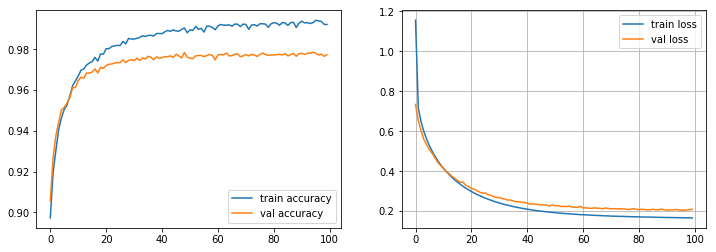

Epoch 99
Train loss, accuracy: 0.16615887810076246 0.9922
Val loss, accuracy: 0.20936425465160954 0.9774
Test accuracy: 0.9767
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 100)                  78500
_________________________________________________________________
relu_1 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 100)                  10100
_________________________________________________________________
relu_2 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 100)                  10100
_________________________________________________________________
relu_3 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_4 (Layer)              (None, 10)

In [35]:
# L2 regularization
params['uids'] = get_uids()
params['dense_reg']['reg_fn']='l2'
params['dense_reg']['l2_scale']=0.001
nw_II_reg, log_II_reg, w_II_reg = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=100, idx='_II_reg', get_init_w=True)

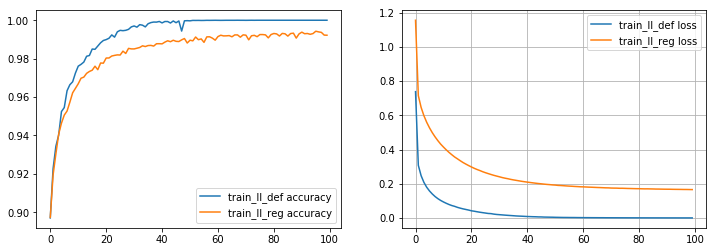

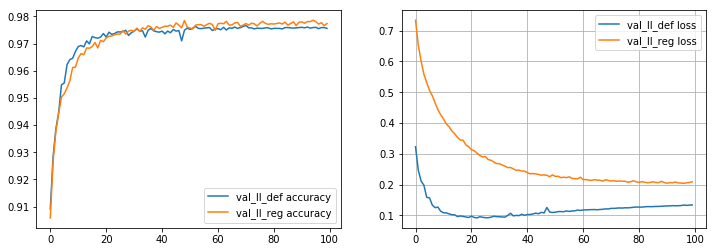

Diff between train/val accuracy w L2 regulizer: 1.4916347510582468% and wo: 2.4399999999999977%


In [36]:
# Compare performance. Check if regularization mitigates overfitting in case of abundantly large number of neuron

log_comp_II = {**log_II_def, **log_II_reg}
plot(log_comp_II, keys=['train'])
plot(log_comp_II, keys=['val'], clr=False)
keys = [key for key, _ in log_comp_II.items()]

diff = (log_II_def[keys[0]]['accuracy'][-1]-log_II_def[keys[1]]['accuracy'][-1])*100/log_II_def[keys[0]]['accuracy'][-1]
diff_reg = (log_II_reg[keys[2]]['accuracy'][-1]-log_II_reg[keys[3]]['accuracy'][-1])*100/log_II_reg[keys[2]]['accuracy'][-1]
print('Diff between train/val accuracy w L2 regulizer: {}% and wo: {}%'.format(diff_reg, diff))

Sum of weights of 1st layer for network with regularization: 979.2688185928719 vs wo 3611.8266689375973
Sum of weights of all layers for network with regularization: 1806.3406432719685 vs wo 5925.472677572493


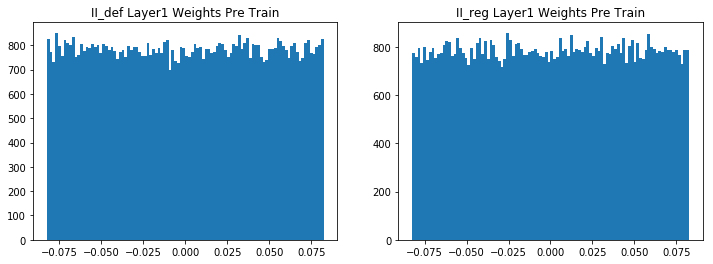

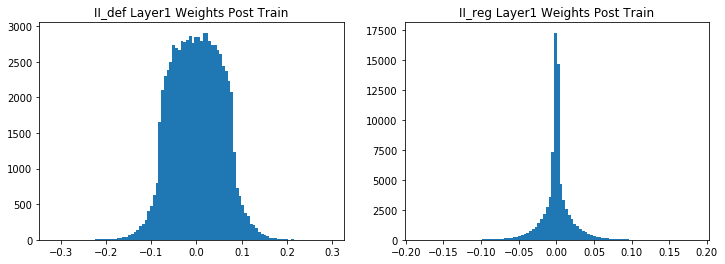

In [37]:
sum_w = 0
for layer in nw_II_def:
    if isinstance(layer, Dense):
        sum_w += np.sum(np.abs(layer.weights))
        
sum_w_reg = 0
for layer in nw_II_reg:
    if isinstance(layer, Dense):
        sum_w_reg += np.sum(np.abs(layer.weights))
        
print('Sum of weights of 1st layer for network with regularization: {} vs wo {}'.format(abs(nw_II_reg[0].weights).sum(), abs(nw_II_def[0].weights).sum()))
print('Sum of weights of all layers for network with regularization: {} vs wo {}'.format(sum_w_reg, sum_w))


plot_weights(w_II_def, w_II_reg, ['II_def Layer1 Weights Pre Train', 'II_reg Layer1 Weights Pre Train'])
plot_weights(nw_II_def[0].weights, nw_II_reg[0].weights, ['II_def Layer1 Weights Post Train', 'II_reg Layer1 Weights Post Train'])

L2 regularization penalizes the weights parameters without making them sparse. L2 regularizer has a big impact on the directions of the weight vector that don’t “contribute” much to the loss function. On the other hand, it has a relatively small effect on the directions that contribute to the loss function. As a result, model variance reduces, which makes it easier to generalize on unseen data. 

As can be seen from experiment above, while the validation data loss increases in network without regularization, an indicator of overfit, it does not in network with regularization. L2 regularization improves the behavior of the model as can be seen by lower difference between training/validation loss/accuracy

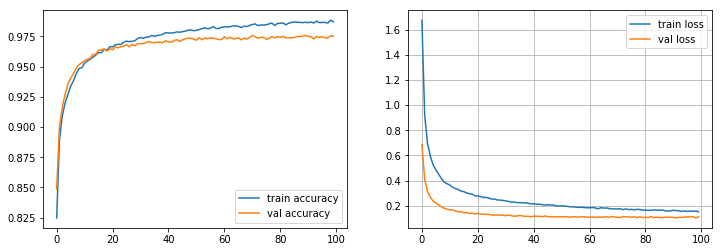

Epoch 99
Train loss, accuracy: 0.15144530771711337 0.98724
Val loss, accuracy: 0.11151446467363182 0.9751
Test accuracy: 0.9691
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 100)                  78500
_________________________________________________________________
relu_1 (Activation)          (None, 100)                  0
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 100)                  10100
_________________________________________________________________
relu_2 (Activation)          (None, 100)                  0
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)                  0
_________________________________________________________________
dense_3 (Layer)              (None, 100)  

In [41]:
# With Dropout

hlayer_dims=[100, 100, 100]
params = get_default_params()
params['learning_rate']=0.01
params['init_fn']='xavier_uniform'
params['drop_prob']=0.5
nw_DO, log_DO, _ = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=100, idx='DO')

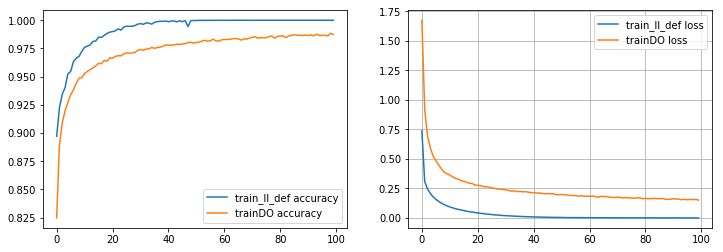

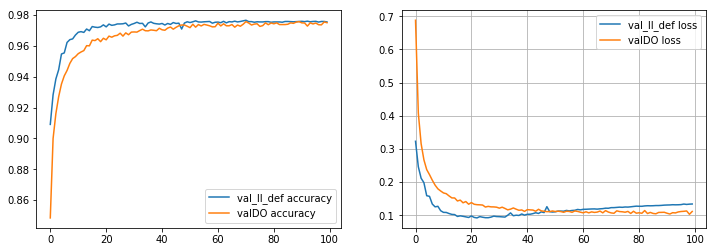

In [42]:
# Compare Performance with and without Dropout

log_comp_DO = {**log_II_def, **log_DO}
plot(log_comp_DO, keys=['train'])
plot(log_comp_DO, keys=['val'], clr=False)

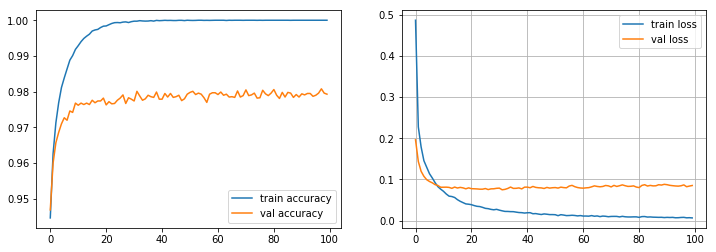

Epoch 99
Train loss, accuracy: 0.006704201973221623 1.0
Val loss, accuracy: 0.08538362939781444 0.9793
Test accuracy: 0.9792
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 100)                  78500
_________________________________________________________________
BatchNorm_1 (BatchNormalization)(None, 100)                  400
_________________________________________________________________
relu_1 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 100)                  10100
_________________________________________________________________
BatchNorm_2 (BatchNormalization)(None, 100)                  400
_________________________________________________________________
relu_2 (Activation)          (None, 100)                  0
_________________________________________________________________
dense_3 (Layer)              (None,

In [43]:
# Batch normalization

hlayer_dims=[100, 100, 100]
params = get_default_params()
params['learning_rate']=0.01
params['init_fn']='xavier_uniform'
params['bn']=True
nwBN, log_BN, w_BN = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=100, idx='BN', get_init_w=True)

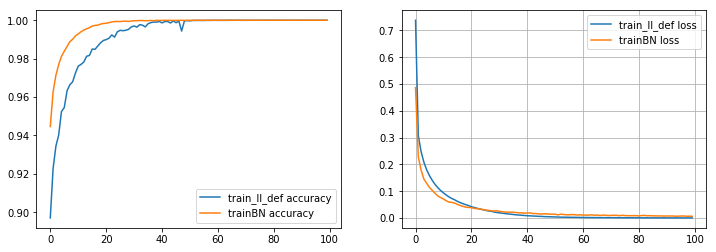

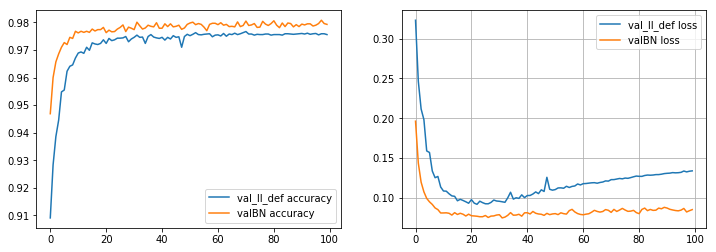

In [44]:
# Compare Performance with and without Batch normalization

log_comp_BN = {**log_II_def, **log_BN}
plot(log_comp_BN, keys=['train'])
plot(log_comp_BN, keys=['val'], clr=False)

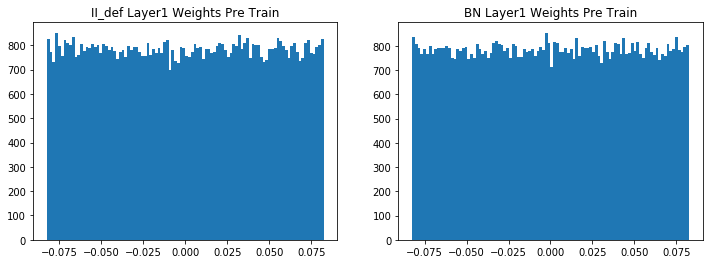

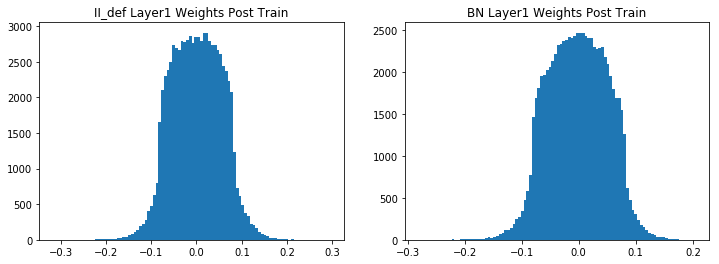

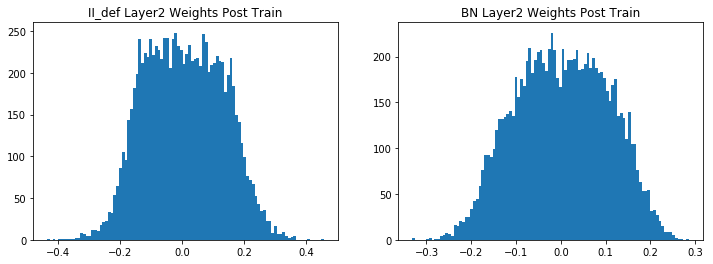

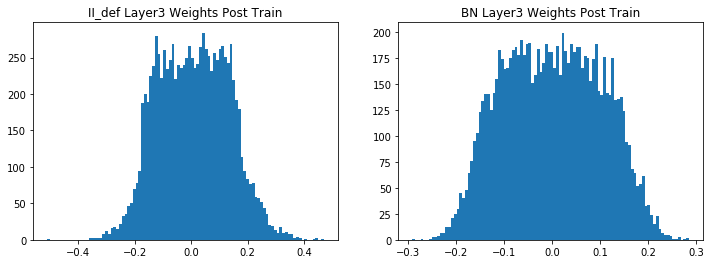

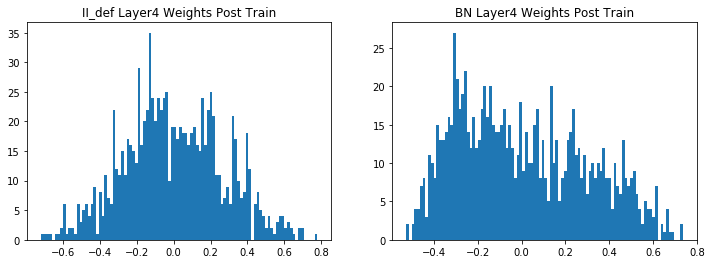

In [45]:
# Visualize weights of All Layers
plot_weights(w_II_def, w_BN, ['II_def Layer1 Weights Pre Train', 'BN Layer1 Weights Pre Train'])

plot_weights(nw_II_def[0].weights, nwBN[0].weights, ['II_def Layer1 Weights Post Train', 'BN Layer1 Weights Post Train'])
plot_weights(nw_II_def[2].weights, nwBN[3].weights, ['II_def Layer2 Weights Post Train', 'BN Layer2 Weights Post Train'])
plot_weights(nw_II_def[4].weights, nwBN[6].weights, ['II_def Layer3 Weights Post Train', 'BN Layer3 Weights Post Train'])
plot_weights(nw_II_def[6].weights, nwBN[9].weights, ['II_def Layer4 Weights Post Train', 'BN Layer4 Weights Post Train'])

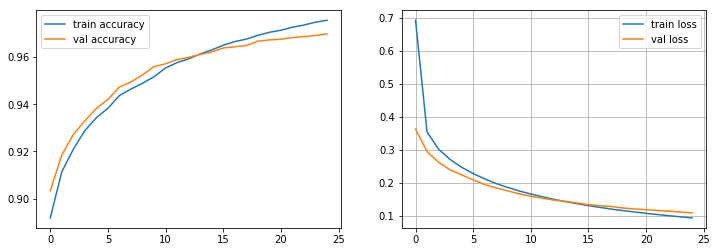

Epoch 24
Train loss, accuracy: 0.09406226580762433 0.97554
Val loss, accuracy: 0.10951390880654746 0.9698
Test accuracy: 0.9691
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 200)                  157000
_________________________________________________________________
relu_1 (Activation)          (None, 200)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 10)                   2010
_________________________________________________________________


In [70]:
# Option III: optimization
# Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

# Vanilla SGD
hlayer_dims = [200]
params = get_default_params()
params['learning_rate']=0.01
params['init_fn']='xavier_uniform'
nw_III_def, log_III_def, _ = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=25, idx='_III_def')

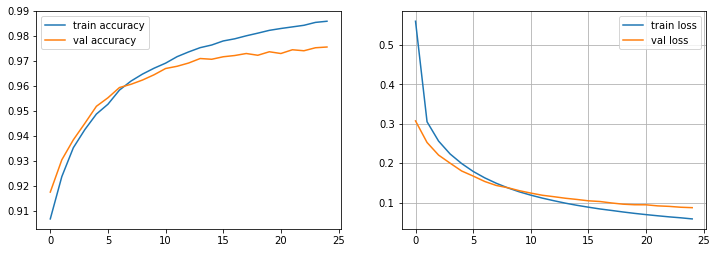

Epoch 24
Train loss, accuracy: 0.05831796165939746 0.9859
Val loss, accuracy: 0.08688870462633637 0.9756
Test accuracy: 0.9749
Layer (type)                 Output Shape                 Param #
dense_1 (Layer)              (None, 200)                  157000
_________________________________________________________________
relu_1 (Activation)          (None, 200)                  0
_________________________________________________________________
dense_2 (Layer)              (None, 10)                   2010
_________________________________________________________________


In [71]:
# SGD with momentum & nesterov
params['uids'] = get_uids()
params['momentum']=0.7
params['nesterov']=True
nw_III_opt, log_III_opt, _ = create_and_train_model(params, hlayer_dims=hlayer_dims, epochs=25, idx='_III_opt')

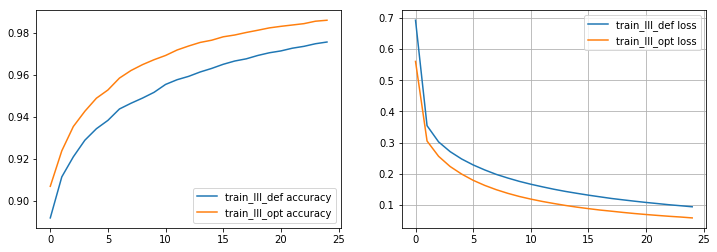

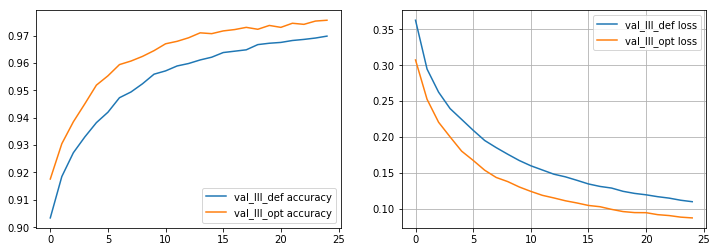

In [72]:
# Show how your chosen method performs compared to vanilla SGD

log_comp_III = {**log_III_def, **log_III_opt}
plot(log_comp_III, keys=['train'])
plot(log_comp_III, keys=['val'], clr=False)

As can be seen from above plots, Momentum helps accelerate SGD